# Importing Libraries

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

# To run on hardware, selectthe backedn with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

In [2]:
import numpy as np
from qiskit.quantum_info import Statevector, Operator
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_distribution
import qiskit.circuit.library as qulib
from qiskit_aer import AerSimulator
from qiskit import transpile

## Parameters

In [3]:
n = 5 # n=5, N=2**n
N = 2**n
Vx = -0.5
alpha = 1 + Vx
beta = -0.5
gamma= -0.5

In [4]:
super_diag=np.ones(N-1) * gamma
main_diag=np.ones(N) * alpha
sub_diag=np.ones(N-1) * beta

tridiag_A=np.diag(main_diag) + np.diag(sub_diag, k=-1) + np.diag(super_diag, k=1)
print(tridiag_A)

[[ 0.5 -0.5  0.  ...  0.   0.   0. ]
 [-0.5  0.5 -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5 -0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.5 -0.5]
 [ 0.   0.   0.  ...  0.  -0.5  0.5]]


In [5]:
def TridiagonalBlockEncoding(circuit, A):
    # Sparse Block encoding
    n = int(np.log2(A.shape[0]))
    m = 2 # Number of Ancilla Qubits
    s = 2 ** m
    Tridiagblckencd = QuantumCircuit(n+m+1,name="Tridiagblckencd")
    # Diffusion Operator
    Diffusion = QuantumCircuit(m,name="Diffusion")
    Diffusion.h(range(m))
    Tridiagblckencd.append(Diffusion, list(range(1,m+1)))

    #OA circuit
    OA = QuantumCircuit(n+m+1,name="OA")
    theta0=2*np.arccos(tridiag_A[0,0]-1)
    theta1=2*np.arccos(tridiag_A[1,0])
    theta2=2*np.arccos(tridiag_A[0,1])

    OA.append(qulib.RYGate(theta0).control(2,ctrl_state="00"),[2,1,0])
    OA.append(qulib.RYGate(theta1).control(2,ctrl_state="01"),[2,1,0])
    OA.append(qulib.RYGate(theta2).control(2,ctrl_state="10"),[2,1,0])
    str="01"+"1"*n
    OA.append(qulib.RYGate(np.pi - theta1).control(n+m,ctrl_state=str),list(range(n+m,-1,-1)))
    str="10"+"0"*n
    OA.append(qulib.RYGate(np.pi - theta2).control(n+m,ctrl_state=str),list(range(n+m,-1,-1)))

    Tridiagblckencd.append(OA, list(range(0,n+m+1)))
    
    #Oc Circuit
    Oc = QuantumCircuit(n+m,name="Oc")
    #Lshift Operator
    Lshift = QuantumCircuit(n,name="Lshift")
    for i in range(n-1):
        Lshift.append(qulib.XGate().control(n-i-1),list(range(n-1,i-1,-1)))
    Lshift.x(n-1)
    Oc.append(qulib.UnitaryGate(Operator(Lshift),label="Lshift").control(1),[1]+list(range(m,n+m)))
    
    #RShift Operator
    Rshift = QuantumCircuit(n,name="Rshift")
    for i in range(n-1):
        str='0'*(n-i-1)
        Rshift.append(qulib.XGate().control(n-i-1,ctrl_state=str),list(range(n-1,i-1,-1)))
    Rshift.x(n-1)
    Oc.append(qulib.UnitaryGate(Operator(Rshift),label="Rshift").control(1),[0]+list(range(m,n+m)))
    #Tridiagblckencd.append(Oc, list(range(1,n+m+1)))
    Tridiagblckencd.append(Oc, list(range(1,n+m+1)))

    # Diffusion Operator
    Tridiagblckencd.append(Diffusion, list(range(1,m+1)))
    
    circuit.append(Tridiagblckencd, list(range(0,n+m+1)))
    
    return circuit
    

# Simulator

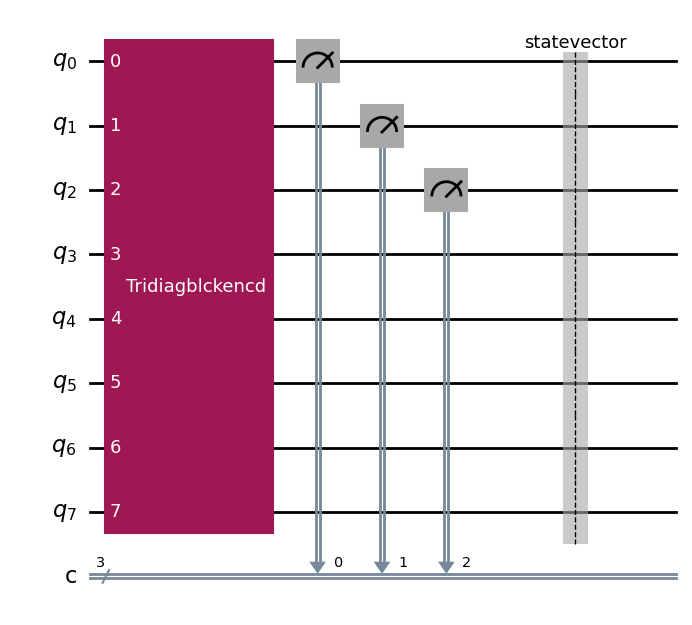

In [6]:
ancilla = 3
backend = AerSimulator()

qubits = QuantumRegister(n + ancilla,name="q")
cbits = ClassicalRegister(ancilla,name="c")
circuit = QuantumCircuit(qubits,cbits)

circuit = TridiagonalBlockEncoding(circuit, tridiag_A)
# U =qi.Operator(circuit)
# print("Dimension of U: ", U.dim)
circuit.measure(range(ancilla), range(ancilla))
circuit.save_statevector()
circuit.draw('mpl')

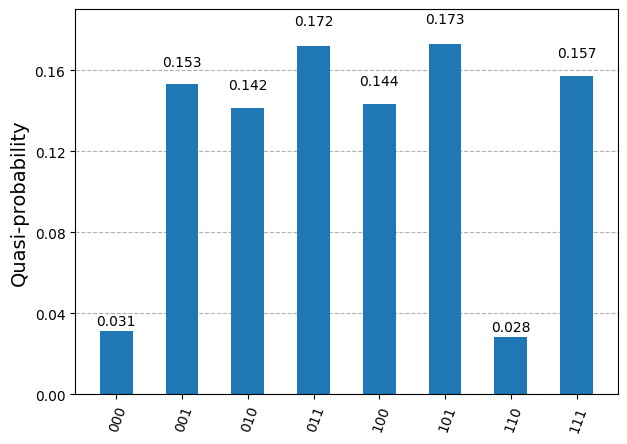

In [9]:
result = backend.run(transpile(circuit,backend,optimization_level=3),shots=1024).result()
#psi = result.get_statevector()
counts = result.get_counts()
plot_distribution(counts)
#display(psi.draw("latex"))